In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupShuffleSplit, GroupKFold

%matplotlib inline

### load data

In [2]:
train_df = pd.read_csv('./data/train.csv')
train_checks_df = pd.read_csv('./data/train_checks.csv')

test_df = pd.read_csv('./data/test.csv')
test_checks_df = pd.read_csv('./data/test_checks.csv')

In [3]:
train_df.head()

,check_id,name,category,price,count
0,0,*3479755 ТRUF.Конф.кр.корп.гл.вк.шок180г,Чай и сладкое,49.0,2.0
1,0,3408392 ECONTA Мешки д/мусора 30л 30шт,Для дома,21.0,1.0
2,0,3260497 ЯШКИНО Рулет С ВАР.СГУЩ. 200г,Чай и сладкое,39.0,1.0
3,0,3300573 Пакет ПЯТЕРОЧКА 65х40см,Упаковка,4.0,1.0
4,0,3413607 ЗЕР/СЕЛ.Сухари с изюмом 250г,Чай и сладкое,35.0,1.0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13682 entries, 0 to 13681
Data columns (total 5 columns):
check_id    13682 non-null int64
name        13681 non-null object
category    13682 non-null object
price       13682 non-null float64
count       13682 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 534.5+ KB


In [5]:
train_df['category'].unique()

array(['Чай и сладкое', 'Для дома', 'Упаковка', 'Молочка', 'Бакалея',
       'Дети', 'Овощи и фрукты', 'Напитки', 'Здоровье', 'Косметика',
       'Гастрономия', 'Кафе', 'Мясо и птица', 'Хлеб', 'Услуги',
       'Одежда и обувь', 'Рыба', 'Машина', 'Не определена', 'Животные',
       'Кулинария', 'Алкоголь', 'Снеки', 'Табак', 'Компьютер'],
      dtype=object)

In [6]:
train_df.fillna('', inplace=True)

In [7]:
train_checks_df.head()

,check_id,shop_name,datetime,sum
0,0,Не известно,2017-12-30 19:15:00,520.10
1,1,ЕВРОПА,2018-01-03 18:01:29,188.00
2,2,ПродвижениеФарм,2017-12-23 11:37:00,377.00
3,3,Не известно,2017-12-23 14:01:00,1024.00
4,4,ИП Роздухов М. Е.,2018-01-03 12:24:00,1542.16


In [8]:
train_checks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 4 columns):
check_id     2042 non-null int64
shop_name    1967 non-null object
datetime     2042 non-null object
sum          2042 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 63.9+ KB


### prepare data

In [9]:
remove_sep_transform = lambda val: val.replace('/', ' ').replace('*', ' ')
no_digits_transform = lambda val: ' '.join([token for token in val.split() if not token.isdigit()])

In [10]:
train_df['name_nodigits'] = train_df['name'].apply(remove_sep_transform).apply(no_digits_transform)
test_df['name_nodigits'] = test_df['name'].apply(remove_sep_transform).apply(no_digits_transform)

In [11]:
train_df['name_nodigits'].head()

0    ТRUF.Конф.кр.корп.гл.вк.шок180г
1     ECONTA Мешки д мусора 30л 30шт
2      ЯШКИНО Рулет С ВАР.СГУЩ. 200г
3            Пакет ПЯТЕРОЧКА 65х40см
4       ЗЕР СЕЛ.Сухари с изюмом 250г
Name: name_nodigits, dtype: object

In [12]:
vectorizer = CountVectorizer()

In [13]:
%%time

#X = vectorizer.fit_transform(train_df['name'])
X = vectorizer.fit_transform(train_df['name_nodigits'])

Wall time: 116 ms


In [14]:
list(vectorizer.vocabulary_.items())[:10]

[('тruf', 12074),
 ('конф', 7260),
 ('кр', 7409),
 ('корп', 7349),
 ('гл', 5460),
 ('вк', 5150),
 ('шок180г', 13479),
 ('econta', 2239),
 ('мешки', 8394),
 ('мусора', 8719)]

In [15]:
X.shape

(13682, 13818)

In [16]:
labeler = LabelEncoder()

In [17]:
%%time

y = labeler.fit_transform(train_df['category'])

Wall time: 26.6 ms


In [18]:
y[:10]

array([24,  4, 24, 21, 24, 24, 12,  1, 12,  3], dtype=int64)

In [19]:
y.shape

(13682,)

### validation

In [20]:
gss = GroupShuffleSplit(n_splits=5, random_state=0)

In [21]:
# 3rd parameter - group labels for the samples used while splitting the dataset into train/test set.)
gss_splits = list(gss.split(X, y, train_df['check_id'].values))

In [22]:
%%time

score = cross_val_score(LogisticRegression(), X, y, scoring='neg_log_loss', cv=gss_splits, n_jobs=-1)
print('score: mean = {} std = {}'.format(-score.mean(), score.std()))

score: mean = 0.7336617669304685 std = 0.020819982256506723
Wall time: 2.38 s


### prepare submission

In [31]:
model = LogisticRegression()

In [32]:
%%time

model.fit(X, y)

Wall time: 797 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
#X_test = vectorizer.transform(test_df['name'])
X_test = vectorizer.transform(test_df['name_nodigits'])

In [34]:
predictions = model.predict_proba(X_test)

In [35]:
predictions_df = test_df[['id']]

In [36]:
for idx, category in enumerate(labeler.classes_):
    predictions_df = pd.concat([predictions_df, pd.Series(predictions[:, idx], name=category)], axis=1)

In [37]:
predictions_df.to_csv('./submissions/starter_submission.csv', encoding='utf-8', index=False)

### misclassification analysis

In [38]:
gkf = GroupKFold(n_splits=5)

gkf_splits = list(gkf.split(X, y, train_df['check_id'].values))

In [39]:
%%time

cv_predicts = cross_val_predict(LogisticRegression(), X, y, cv=gkf_splits, method='predict_proba', n_jobs=-1)
#cv_predicts = 1 - cv_predicts
#cv_predicts[np.arange(len(cv_predicts)), y] = 1 - cv_predicts[np.arange(len(cv_predicts)), y]

Wall time: 2.42 s


In [40]:
# reverse predict for actual label
cv_predicts[np.arange(len(cv_predicts)), y] = 1 - cv_predicts[np.arange(len(cv_predicts)), y]

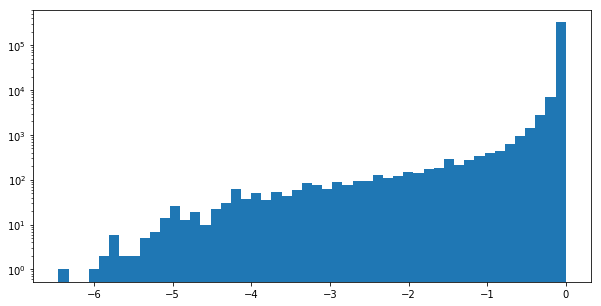

In [41]:
plt.figure(figsize = (10, 5))
plt.hist(np.log(1.0 - cv_predicts.ravel()), bins = 50, log = True)
plt.show()

In [42]:
train_df['category_mistake'] = cv_predicts[np.arange(len(cv_predicts)), y]

train_df['predicted_category'] = cross_val_predict(LogisticRegression(), X, y, cv=gkf_splits, method = 'predict', n_jobs=-1)
train_df['predicted_category'] = labeler.inverse_transform(train_df['predicted_category'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [44]:
train_df.sort_values('category_mistake', ascending = False)[['name_nodigits', 
                                                             'category', 
                                                             'category_mistake', 
                                                             'predicted_category']]

,name_nodigits,category,category_mistake,predicted_category
8393,"ТЕМА Биотв.ЯБЛ МОРК.4,2% 100г",Напитки,0.998427,Дети
6934,"Ледоруб кованый 150мм, вес 2,1кг, рукоятка 1,2м",Для дома,0.997473,Овощи и фрукты
5257,КОП.ДВ.Колб.БРАУН.ОС.с к б с300,Мясо и птица,0.997343,Гастрономия
11693,СЫКТ.Язычок с ветч сыр.80г,Хлеб,0.997267,Гастрономия
12977,ФН Пюре ябл бан гр.с печ.90г,Напитки,0.996972,Дети
7940,ФН Пюре ябл бан гр.с печ.90г,Напитки,0.996972,Дети
1082,Р к шпроты ВКУСНЫЕ КОНСЕРВЫ В масле 160г,Рыба,0.996925,Гастрономия
1466,Услуга по предоставлению доступа к ПО Kaspersk...,Компьютер,0.996770,Услуги
3829,200МЛ БИОЛАКТ ФРУТОНЯНЯ ЧРНСЛВ,Молочка,0.996757,Дети
6434,КУТАБЫ С ЗЕЛ\СЫР,Кулинария,0.996703,Гастрономия
